In [4]:
import simpy
import random
import statistics
import math
import numpy as np


def customer(env, server, times):
    arrival_time = env.now
    with server.request() as request:
        yield request
        wait = env.now - arrival_time
        times.append(wait)  # Record waiting time
        service_time = random.expovariate(mu)
        yield env.timeout(service_time)

def setup(env, num_servers, lambda_, mu, times):
    server = simpy.Resource(env, num_servers)

    # Continuously create customers
    while True:
        yield env.timeout(random.expovariate(lambda_))
        env.process(customer(env, server, times))

def confidence_interval(data, confidence=0.95):
    mean = statistics.mean(data)
    stdev = statistics.stdev(data)
    n = len(data)
    z = 1.96  # 95% confidence level
    margin = z * (stdev / math.sqrt(n))
    return mean, margin

lambda_ = 10  # Arrival rate
mu = 5        # Service rate
simulation_time = 10000  # Simulation time

# different numbers of servers
for num_servers in [1, 2, 4]:
    wait_times = []
    random.seed(42)
    env = simpy.Environment()
    env.process(setup(env, num_servers, lambda_, mu, wait_times))
    env.run(until=simulation_time)

    average_wait, margin = confidence_interval(wait_times)
    print(f"\nNumber of servers: {num_servers}, Average waiting time: {average_wait:.2f}")
    print(f"Confidence interval: ({average_wait - margin:.2f}, {average_wait + margin:.2f})")
    print(f"Total number of customers: {len(wait_times)}, Standard deviation: {statistics.stdev(wait_times):.2f}")



Number of servers: 1, Average waiting time: 2478.30
Confidence interval: (2465.72, 2490.88)
Total number of customers: 50138, Standard deviation: 1436.72

Number of servers: 2, Average waiting time: 16.98
Confidence interval: (16.90, 17.05)
Total number of customers: 99441, Standard deviation: 11.42

Number of servers: 4, Average waiting time: 0.02
Confidence interval: (0.02, 0.02)
Total number of customers: 99521, Standard deviation: 0.06


In [5]:
from scipy import stats

def anova_test(data):
    f_value, p_value = stats.f_oneway(data[1], data[2], data[4])
    return f_value, p_value

lambda_ = 10  
mu = 5      
simulation_time = 10000 

wait_times_data = {}

for num_servers in [1, 2, 4]:
    wait_times = []
    random.seed(42)
    env = simpy.Environment()
    env.process(setup(env, num_servers, lambda_, mu, wait_times))
    env.run(until=simulation_time)
    wait_times_data[num_servers] = wait_times

f_value, p_value = anova_test(wait_times_data)
print(f"\nImpact of the number of servers on waiting time - ANOVA test result:")
print(f"F-value: {f_value:.2f}, p-value: {p_value:.4f}")

# Determine whether there is a significant difference
if p_value < 0.05:
    print("Different numbers of servers have a significant impact on waiting time.")
else:
    print("Different numbers of servers do not have a significant impact on waiting time.")



Impact of the number of servers on waiting time - ANOVA test result:
F-value: 293964.73, p-value: 0.0000
Different numbers of servers have a significant impact on waiting time.


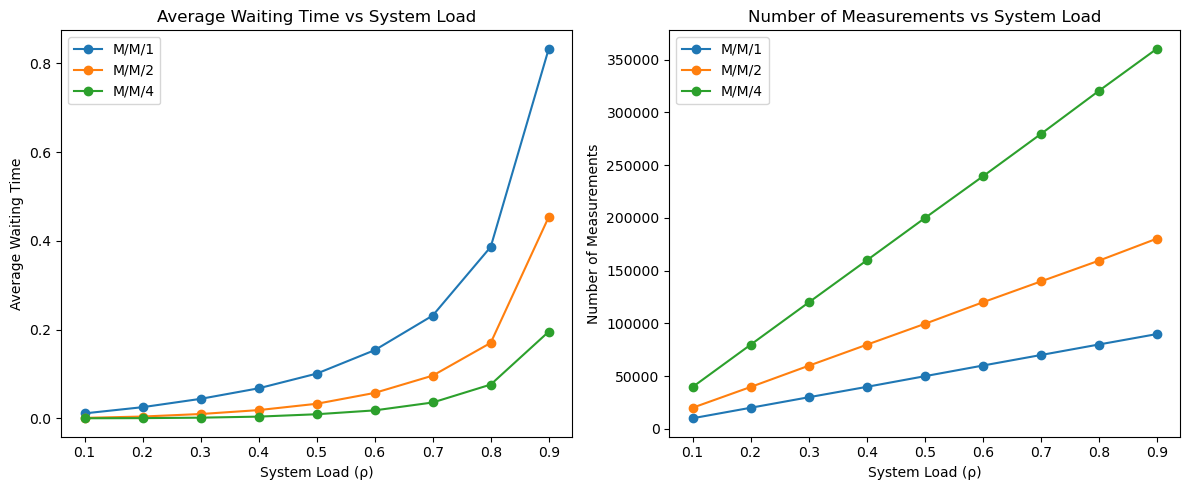

In [6]:
import matplotlib.pyplot as plt

mu = 10  
simulation_time = 10000 
load_levels = np.linspace(0.1, 0.9, 9) 
server_numbers = [1, 2, 4] 

results = {n: {'loads': [], 'average_waits': [], 'measurements': []} for n in server_numbers}

for num_servers in server_numbers:
    for rho in load_levels:
        lambda_ = rho * mu * num_servers  
        wait_times = []
        random.seed(42)
        env = simpy.Environment()
        env.process(setup(env, num_servers, lambda_, mu, wait_times))
        env.run(until=simulation_time)

        results[num_servers]['loads'].append(rho)
        results[num_servers]['average_waits'].append(statistics.mean(wait_times))
        results[num_servers]['measurements'].append(len(wait_times))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for num_servers in server_numbers:
    plt.plot(results[num_servers]['loads'], results[num_servers]['average_waits'], marker='o', label=f'M/M/{num_servers}')
plt.xlabel('System Load (ρ)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs System Load')
plt.legend()

plt.subplot(1, 2, 2)
for num_servers in server_numbers:
    plt.plot(results[num_servers]['loads'], results[num_servers]['measurements'], marker='o', label=f'M/M/{num_servers}')
plt.xlabel('System Load (ρ)')
plt.ylabel('Number of Measurements')
plt.title('Number of Measurements vs System Load')
plt.legend()

plt.tight_layout()
plt.show()
